In [32]:
import ystockquote as yst
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [62]:
data = pd.DataFrame(
            yst.get_historical_prices("AAPL","2015-01-02","2015-10-10"))\
           .transpose()[['Adj Close']].astype(float)
market = pd.DataFrame(
            yst.get_historical_prices("^GSPC","2015-01-02","2015-10-10"))\
           .transpose()[['Adj Close']].astype(float)

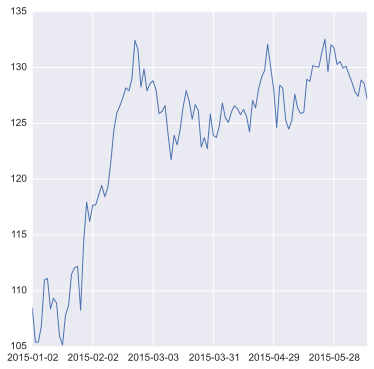

In [7]:
sns.set_style("darkgrid")
data.plot(figsize=(6,6), legend=False, lw=1)
plt.show()

Here I define the daily return as the following for a stock price $S$ at time $t$.

$$r_t = \frac{S_t - S_{t-1}}{S_{t-1}}  $$

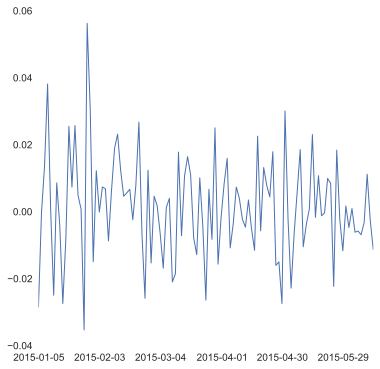

In [63]:
returns = ((data - data.shift(1)) / data.shift(1)).dropna(axis=0)
returns.columns = ['Daily Return']

market_returns = ((market - market.shift(1)) / market.shift(1)).dropna(axis=0)
market_returns.columns = ['Daily Return']

returns.plot(figsize=(6,6), legend=False, lw=1)

Suppose that we are interested in estimating $E[r_t]$, the expected or average value of returns for stock $S$ at time $t$.  While we could use historical data to get a small confidence interval of our estimate, in reality the underlying distribution $D$ from which these returns are drawn has probably changed significantly.  To reduce to chance that our data is unrepresentative, we need to use only recent data. Unfortunately, this also drastically reduces our certainty of the measurement.  How can we possibly get more information about this stock with resorting to historical data (or insider trading)?  We'll answer this with another important topic in finance, the correlation of returns with other stocks and "the market" as a whole.

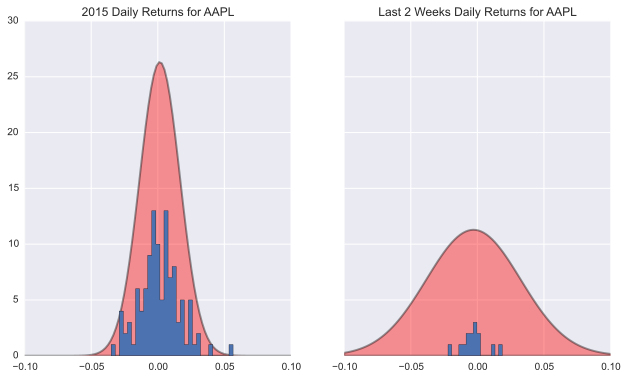

In [84]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(10.5, 6)
data = returns["Daily Return"].values
x = np.linspace(-0.1, 0.1, 100)
y1 = sp.stats.norm.pdf(x, np.mean(data), np.std(data))
y2 = sp.stats.norm.pdf(x, np.mean(data[-14:]), np.std(data[-14:]) * np.sqrt(14))

ax[0].hist(returns["Daily Return"], histtype="stepfilled", bins=30)
ax[0].set_title("2015 Daily Returns for AAPL")
ax[0].fill_between(x, 0, y1, color="red", linewidth=2,
                     edgecolor="black", alpha=0.4)


ax[1].hist(returns["Daily Return"].values[-14:], histtype="stepfilled", bins=15)
ax[1].set_title("Last 2 Weeks Daily Returns for AAPL")
ax[1].fill_between(x, 0, y2, color="red", linewidth=2,
                     edgecolor="black", alpha=0.4)
ax[1].set_xlim(-0.1, 0.1)
plt.show()

Correlation with the overall market, usually measured as a stock's "Beta" is also an import part of building a portfolio.  Stocks with highly correlated returns means large swings in the value of the fund.  If the goal is stead increases in value with low variability, it makes sense to look for stocks with good returns that are uncorrelated with eachother.

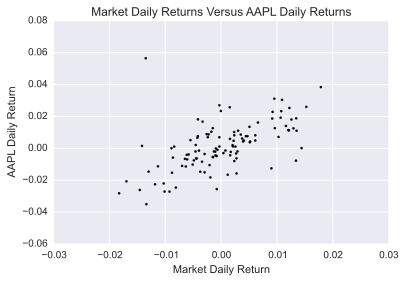

In [68]:
sns.set_style("darkgrid")
plt.scatter(market_returns["Daily Return"], returns["Daily Return"], s=5, color="black")
plt.xlabel("Market Daily Return")
plt.ylabel("AAPL Daily Return")
plt.title("Market Daily Returns Versus AAPL Daily Returns")
plt.show()

Unlike daily returns, a Stock's Beta must be calculated over some interval of time.  Below we use a rolling window to get an idea of how it changes roughly over the course of a year.

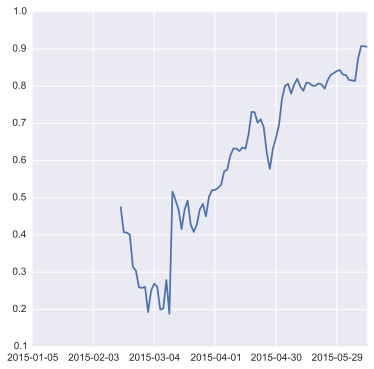

In [77]:
beta = pd.rolling_corr(returns["Daily Return"], market_returns["Daily Return"], 30)
beta.plot(figsize=(6, 6))
plt.show()

So now we're back to our original question - How can we make the most out of only a little information?  We can represent our stock and its relationship with the market as a multivariate normal.  Recall that the multivariate normal distribution is completely defined by a mean vector $\mu$ and a covariance matrix $\Sigma$(sometimes called the variance-covariance matrix).

If we are interested in estimating daily returns, then $E[r_t]$ takes the place in our mean vector.  The diagonal of the covaraince matrix represents the variance $\theta^2$ of each stocks retruns, and the other positions are the covariances between the members.

Now here is where we introduce bayesian statistics - We have some observations of the daily returns, and of the rolling covaraince and variance.  Instead of using point estimates for each and dealing with extremely uncertain answers, we will run full simulations with prior distributions of each parameter and capture the uncertainty in our model.

First lets suppose we just used point estimates, what would our results be?

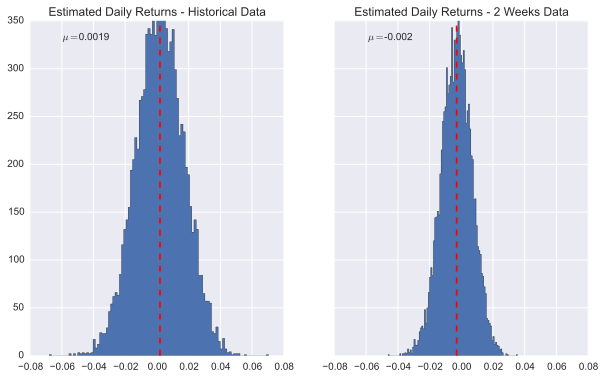

In [116]:
mu = [np.mean(returns["Daily Return"]), np.mean(market_returns["Daily Return"])]
cov = np.cov([returns["Daily Return"], market_returns["Daily Return"]])
sim_1 = np.random.multivariate_normal(mu, cov, 10000)[:, 0]

mu_s = [np.mean(returns["Daily Return"][-14:]), np.mean(market_returns["Daily Return"][-14:])]
cov_s = np.cov([returns["Daily Return"][-14:], market_returns["Daily Return"][-14:]])
sim_2 = np.random.multivariate_normal(mu_s, cov_s, 10000)[:, 0]

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(10, 6)
ax[0].hist(sim_1, bins=100, histtype="stepfilled")
ax[0].set_title("Estimated Daily Returns - Historical Data")
ax[0].plot([np.mean(sim_1), np.mean(sim_1)], [0, 400], color="red", linestyle="--")
ax[0].set_ylim(0, 350)
ax[0].text(0.22, 0.95, "$\mu = $" + str(np.mean(sim_1))[:6], horizontalalignment='center',
     verticalalignment='center',
     transform = ax[0].transAxes)

ax[1].hist(np.random.multivariate_normal(mu_s, cov_s, 10000)[:, 0], bins=100, histtype="stepfilled")
ax[1].set_title("Estimated Daily Returns - 2 Weeks Data")
ax[1].plot([np.mean(sim_2), np.mean(sim_2)], [0, 400], color="red", linestyle="--")
ax[1].text(0.22, 0.95, "$\mu = $" + str(np.mean(sim_2))[:6], horizontalalignment='center',
     verticalalignment='center',
     transform = ax[1].transAxes)
plt.show()

In [165]:
def model():
    n_observations = 50
    prior_mu = np.array([np.mean(returns), np.mean(market_returns)])
    prior_std = np.array([np.std(returns), np.std(market_returns)])
    prior_cov = np.cov(returns["Daily Return"], market_returns["Daily Return"])

    inv_cov_matrix = pm.Wishart("inv_cov_matrix", n_observations, prior_cov)
    mu = pm.Normal("returns", prior_mu[:,0], 1, size=2)
    ret = np.array([returns["Daily Return"].values, market_returns["Daily Return"].values])

    obs = pm.MvNormal("observed returns", mu, inv_cov_matrix, observed=True, value=ret.T)

    M = pm.MCMC(locals())
    M.sample(100000, 5000, 3)

    return M
M = model()

 [-----------------100%-----------------] 100000 of 100000 complete in 43.9 sec

Now that we have created the relationships necessary for our model, we begin using MCMC sampling below

In [166]:
mu_samples = M.trace("returns")[:]

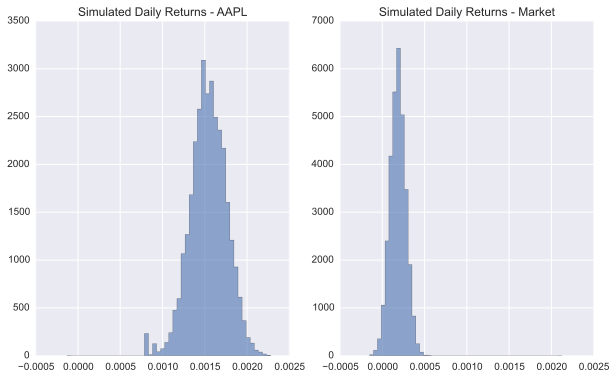

In [182]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
ax[0].hist(mu_samples[:, 0], histtype="stepfilled", bins=50, alpha=0.6)
ax[0].set_title("Simulated Daily Returns - AAPL")

ax[1].hist(mu_samples[:, 1], histtype="stepfilled", bins=50, alpha=0.6)
ax[1].set_title("Simulated Daily Returns - Market")
plt.show()